# Comparación entre K-Nearest Neighbors (KNN) y Árboles de Decisión

Usaremos un dataset **simulado** de 500 pacientes con síntomas para predecir si tienen:
- COVID-19
- Resfriado común
- Gripe

Generaremos datos de manera que los síntomas estén correlacionados con la enfermedad.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
import seaborn as sns

## 1. Generación de datos simulados

Crearemos un dataset con 500 pacientes y las siguientes variables:
- `fiebre` (0-1, fiebre leve a alta)
- `tos` (0-1, nada a fuerte)
- `dolor_muscular` (0-1)
- `perdida_olfato` (0-1)
- `fatiga` (0-1)

Las etiquetas serán `enfermedad` con 3 clases: `COVID-19`, `Resfriado`, `Gripe`.

In [2]:
np.random.seed(42)
n = 500

fiebre = np.random.rand(n)
tos = np.random.rand(n)
dolor_muscular = np.random.rand(n)
perdida_olfato = np.random.rand(n)
fatiga = np.random.rand(n)

labels = []
for i in range(n):
    if perdida_olfato[i] > 0.6 and fiebre[i] > 0.5:
        labels.append("COVID-19")
    elif fiebre[i] > 0.5 and dolor_muscular[i] > 0.4:
        labels.append("Gripe")
    else:
        labels.append("Resfriado")

df = pd.DataFrame({
    'fiebre': fiebre,
    'tos': tos,
    'dolor_muscular': dolor_muscular,
    'perdida_olfato': perdida_olfato,
    'fatiga': fatiga,
    'enfermedad': labels
})

df.head()
#Como tengo la columna enfermedad, esto es APRENDIZAJE SUPERVISADO.

,fiebre,tos,dolor_muscular,perdida_olfato,fatiga,enfermedad
0,0.374540,0.698162,0.185133,0.519082,0.261706,Resfriado
1,0.950714,0.536096,0.541901,0.479182,0.246979,Gripe
2,0.731994,0.309528,0.872946,0.025642,0.906255,Gripe
3,0.598658,0.813795,0.732225,0.341248,0.249546,Gripe
4,0.156019,0.684731,0.806561,0.380196,0.271950,Resfriado


## 2. División en entrenamiento y prueba

In [3]:
X = df.drop('enfermedad', axis=1)
y = df['enfermedad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

El **modelo KNN (K-Nearest Neighbors)** se basa en distancias (por defecto, Euclídea).

**Ejemplo:**
Si una variable está en el rango 0–1 (como tos) y otra en el rango 0–100 (como edad si la tuviéramos), la segunda dominaría el cálculo de distancias aunque no sea tan relevante.

Al escalar con `scaler = StandardScaler()` , todas las variables quedan en la misma escala, evitando que una característica “pese” más que otra solo por sus unidades o rango.

## 3. Modelo K-Nearest Neighbors (KNN)

Parámetros importantes:
- `n_neighbors (k)`: número de vecinos a considerar.
- `weights`: puede ser `uniform` (todos los vecinos pesan igual) o `distance` (vecinos cercanos pesan más).
- `metric`: cómo se mide la distancia (Euclidiana por defecto).

###**Parámetro 1:** `n_neighbors=5`
Este es el famoso k en KNN.

Significa que para predecir la clase de un nuevo punto, el modelo mira a los 5 vecinos más cercanos en el conjunto de entrenamiento.

La clase que "gane" entre esos 5 vecinos es la que se asigna como predicción.

**Ejemplo:**
Si los 5 vecinos más cercanos son:
- 3 casos de Gripe
- 2 casos de Resfriado

*El modelo predice Gripe.*


**k pequeño (ej. 1 o 3)**: muy sensible al ruido (puede sobreajustar).

**k grande (ej. 20):** más estable, pero puede suavizar demasiado y perder detalle.

###**Parámetro 2:** `weights='distance'`

Define cómo se cuentan los votos de los vecinos.

**Opciones:**

- `"uniform"` (por defecto):

Todos los vecinos pesan igual, sin importar la distancia.

**Ejemplo:**
*un vecino muy cercano y otro lejano valen lo mismo.*

- `"distance":`

Los vecinos más cercanos tienen más peso que los lejanos.

Matemáticamente, el peso suele ser
1/distancia.

**Ejemplo:**
*Un punto está más cerca de un paciente con COVID-19, pero dentro de sus 5 vecinos hay más casos de Resfriado.*

###**Resumen:**
- Con `weights='uniform'` → gana Resfriado.

- Con `weights='distance'` → puede ganar COVID-19, porque el vecino más cercano tiene más peso.

**Efecto:**

`"distance"` suele mejorar la precisión cuando los datos tienen clases mezcladas en la frontera.

In [4]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

#Entrenamiento (dataset de prueba)
knn.fit(X_train_scaled, y_train)

#Prediccion (dataset de entrenamiento)
y_pred_knn = knn.predict(X_test_scaled)

#Resultados
print("Métricas KNN:")
print(classification_report(y_test, y_pred_knn))


Métricas KNN:
              precision    recall  f1-score   support

    COVID-19       0.90      0.79      0.84        24
       Gripe       0.74      0.97      0.84        29
   Resfriado       0.96      0.90      0.93        97

    accuracy                           0.89       150
   macro avg       0.87      0.88      0.87       150
weighted avg       0.91      0.89      0.90       150




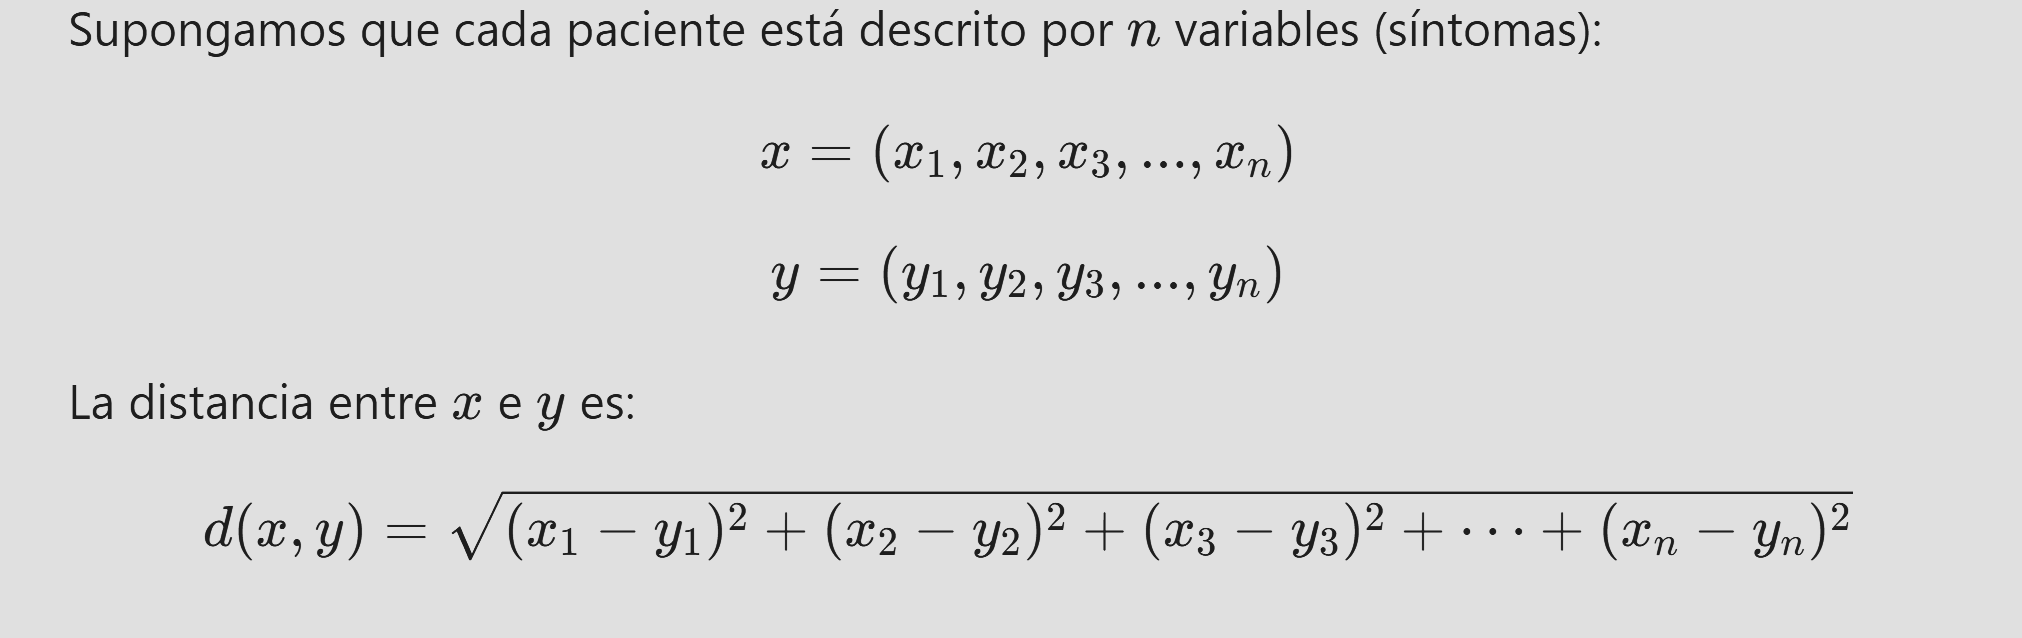

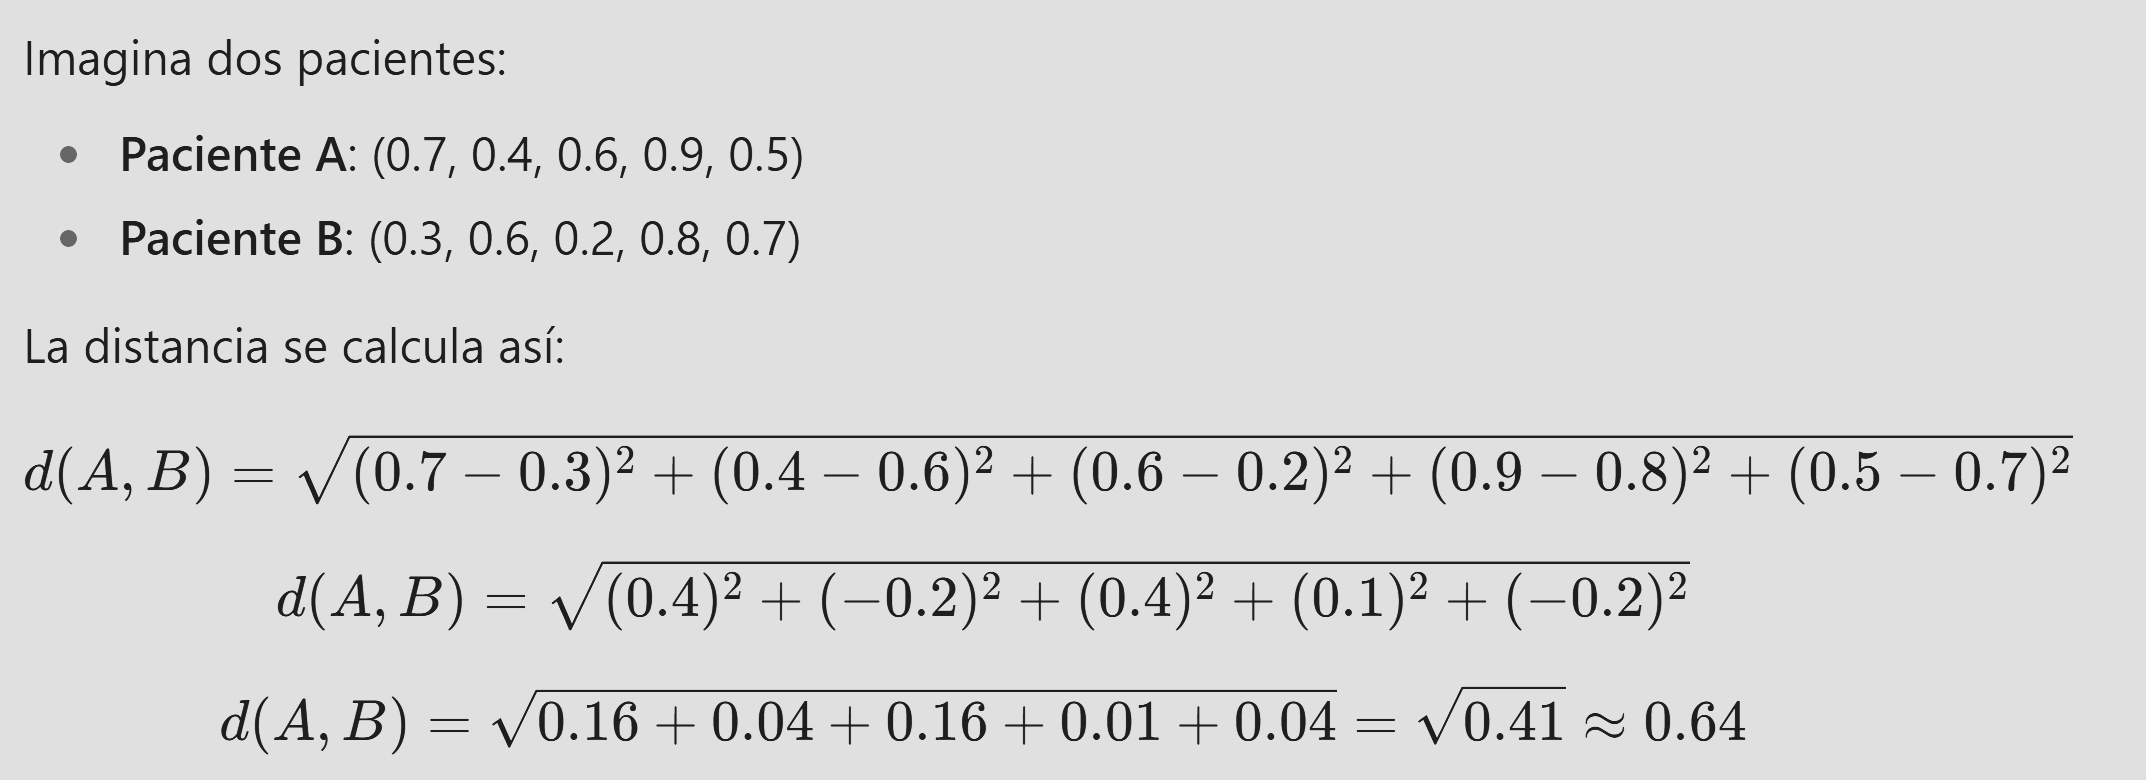

## 4. Árbol de Decisión

Parámetros importantes:
- `criterion`: mide la calidad de la división (gini o entropy).
- `max_depth`: profundidad máxima del árbol.
- `min_samples_split`: número mínimo de muestras para dividir un nodo.
- `min_samples_leaf`: número mínimo de muestras en una hoja.

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Métricas Árbol de Decisión:")
print(classification_report(y_test, y_pred_tree))

Métricas Árbol de Decisión:
              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00        24
       Gripe       1.00      1.00      1.00        29
   Resfriado       1.00      1.00      1.00        97

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



**Parámetro**
`criterion`

Cuando construimos un árbol de decisión, en cada nodo debemos decidir qué atributo usar para dividir los datos.
La idea es elegir la división que mejor separe las clases.

Para eso usamos medidas de impureza:

**Impureza baja** → los elementos están mayormente en una sola clase (nodo “puro”).

**Impureza alta** → las clases están mezcladas.

El Índice Gini mide la probabilidad de que un elemento escogido al azar sea clasificado incorrectamente si seguimos la distribución de clases del nodo.

    Ejemplo: Nodo con 10 elementos: 7 de la clase A y 3 de la clase B.

Probabilidades:
clase a = 7/10 79%
clase b = 3/10 30%

Un valor de 0 significa pureza total (todas las instancias son de la misma clase).
Valores más cercanos a 0 → más puro.

- **Gini** suele ser más rápido.

- **Entropy** (el otro parámetro aceptado) puede ser más interpretativo - relacionado a la teoría de la información de Claude Shannon de 1948.

En la práctica, suelen dar resultados muy parecidos.

`max_depth`

Es el parametro mas importante.

Es la profundidad máxima del árbol (cuántas veces puede dividirse desde la raíz hasta una hoja).

    - Si es muy grande → el árbol crece mucho, aprende hasta el ruido → sobreajuste (overfitting).
    - Si es muy pequeño** → el árbol es muy general → subajuste (underfitting).

    Ejemplo:
    max_depth=1 → es un stump (solo una división).
    max_depth=10 → puede capturar relaciones muy complejas.

`min_samples_split`

Número mínimo de muestras que debe haber en un nodo para permitir dividirlo en dos ramas.

    - Si es muy bajo (ej. 2) → el árbol se divide demasiado → riesgo de sobreajuste.
    - Si es alto (ej. 50) → el árbol no dividirá nodos con pocos datos → modelo más simple, evita ramas inútiles.
    
    Ejemplo:
    Si min_samples_split=20 y un nodo tiene 15 muestras → ese nodo se convierte en hoja, no se divide más.

`min_samples_leaf`

Número mínimo de muestras que debe haber en cada hoja del árbol.

    - Si es muy bajo (ej. 1) → hojas muy pequeñas → el árbol memoriza casos individuales → sobreajuste.
    - Si es alto (ej. 10 o más) → obliga a que las hojas tengan suficiente información → modelo más estable y general.
    
    Ejemplo:
    Si min_samples_leaf=5 y al dividir un nodo una rama queda con 3 ejemplos → esa división no se hace.

**Apliquemos al árbol diagnosticando enfermedades:**

- criterion → cómo decide cuál síntoma es mejor para separar enfermedades (qué criterio usa para elegir la “pregunta”).

- max_depth → hasta qué nivel de detalle está dispuesto a preguntar antes de decidir el diagnóstico.

- min_samples_split → no hace una nueva “pregunta” si no hay suficientes pacientes en ese grupo.

- min_samples_leaf → no se permite un diagnóstico final basado en muy pocos pacientes (evita hojas demasiado pequeñas).

## 5. Evaluación de métricas
- **Accuracy (Exactitud):** proporción de predicciones correctas.
- **Precision (Precisión):** de los predichos como positivos, cuántos lo son realmente.
- **Recall (Sensibilidad):** de los positivos reales, cuántos fueron detectados.
- **F1-score:** media armónica entre precisión y recall.

Accuracy KNN: 0.8933333333333333
Accuracy Árbol: 1.0


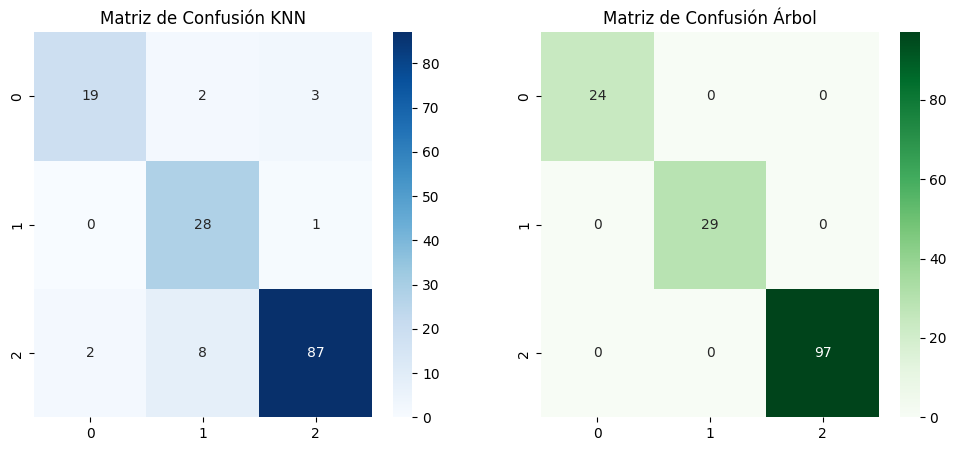

In [ ]:
print("Accuracy KNN:", accuracy_score(y_test, y_pred_knn))
print("Accuracy Árbol:", accuracy_score(y_test, y_pred_tree))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", ax=ax[0], cmap="Blues")
ax[0].set_title("Matriz de Confusión KNN")

sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt="d", ax=ax[1], cmap="Greens")
ax[1].set_title("Matriz de Confusión Árbol")
plt.show()

# 0 = COVID
# 1 = Resfriado
# 2 = Gripe

## 6. Visualización de fronteras de decisión (KNN)

Para simplificar, tomamos solo 2 variables (`fiebre`, `perdida_olfato`).

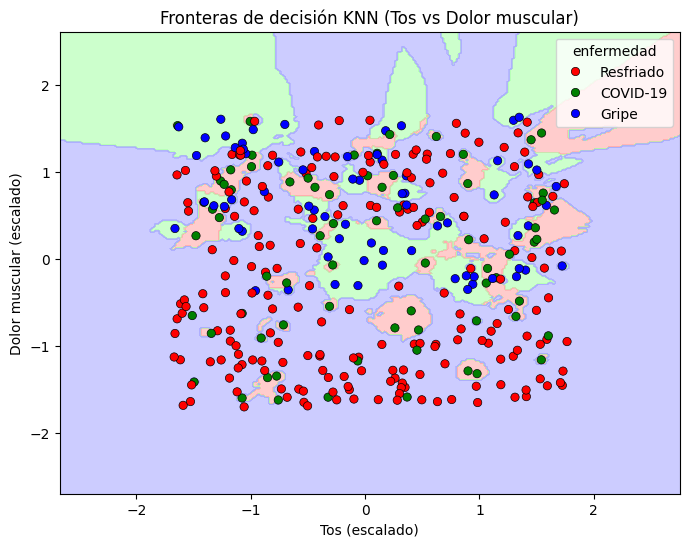

In [ ]:
# Visualización en 2D del modelo KNN usando 'tos' y 'dolor_muscular'

# Seleccionamos solo dos variables
X_simple2 = df[["tos", "dolor_muscular"]]
y_simple2 = df["enfermedad"]

# División en entrenamiento y prueba
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    X_simple2, y_simple2, test_size=0.3, random_state=42
)

# Escalamos los datos
scaler = StandardScaler()
X_train_s2_scaled = scaler.fit_transform(X_train_s2)
X_test_s2_scaled = scaler.transform(X_test_s2)

# Entrenamos el modelo KNN
knn_simple2 = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_simple2.fit(X_train_s2_scaled, y_train_s2)

# Definimos malla (meshgrid)
h = .02
x_min, x_max = X_train_s2_scaled[:, 0].min() - 1, X_train_s2_scaled[:, 0].max() + 1
y_min, y_max = X_train_s2_scaled[:, 1].min() - 1, X_train_s2_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predicciones para cada punto de la malla
Z = knn_simple2.predict(np.c_[xx.ravel(), yy.ravel()])

# Convert string labels to numerical values for plotting
label_map = {"COVID-19": 0, "Gripe": 1, "Resfriado": 2}
Z = np.array([label_map[label] for label in Z])

Z = Z.reshape(xx.shape)


# Colores
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ["red", "green", "blue"]

# Gráfico
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
sns.scatterplot(
    x=X_train_s2_scaled[:, 0],
    y=X_train_s2_scaled[:, 1],
    hue=y_train_s2,
    palette=cmap_bold,
    edgecolor="k"
)
plt.title("Fronteras de decisión KNN (Tos vs Dolor muscular)")
plt.xlabel("Tos (escalado)")
plt.ylabel("Dolor muscular (escalado)")
plt.show()

## 7. Visualización del Árbol de Decisión

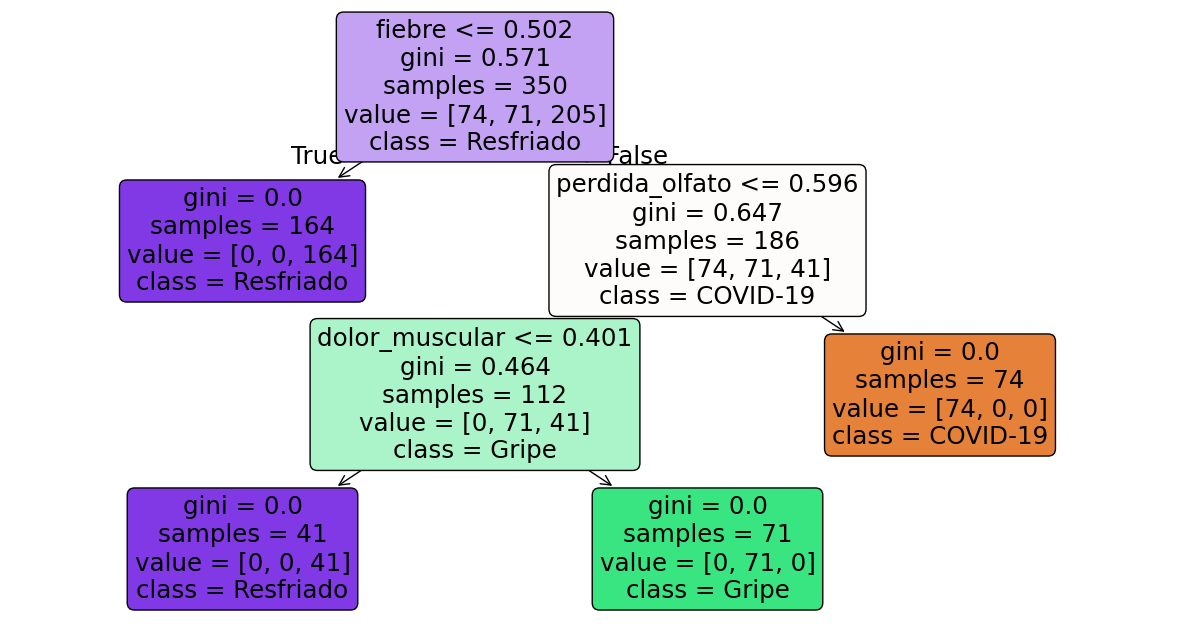

In [ ]:
plt.figure(figsize=(15,8))
plot_tree(tree, feature_names=X.columns, class_names=tree.classes_, filled=True, rounded=True)
plt.show()